In [1]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import igraph as ig
from sklearn.decomposition import NMF

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from dream.genetic_algorithm.coverage_sum import coverage_sum

In [2]:
from matplotlib.ticker import FormatStrFormatter

def plot_run_summary(logs, ax):
    ax.set_xlabel("Generation", fontsize=18)
    ax.set_ylabel("Nr. Drugs", fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)    
    ax.plot(logs["gen"].values, logs["n_drugs"].values, color="C0")
    ax.yaxis.label.set_color("C0")
    ax.spines['left'].set_color('C0')
    ax.tick_params(axis='y', colors='C0')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    

    smiles_ax = ax.twinx()
    smiles_ax.tick_params(axis='y', labelsize=16)
    smiles_ax.set_ylabel("SMILES distances", fontsize=18)
    smiles_ax.plot(logs["gen"].values, logs["avg_smile"].values, color="C1")
    smiles_ax.yaxis.label.set_color("C1")
    smiles_ax.spines['left'].set_color('C1')
    smiles_ax.tick_params(axis='y', colors='C1')
    smiles_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    moa_ax = ax.twinx()
    moa_ax.tick_params(axis='y', labelsize=16)
    moa_ax.set_ylabel("MOA distances", fontsize=18)
    moa_ax.plot(logs["gen"].values, logs["avg_moa"].values, color="C2")
    moa_ax.yaxis.label.set_color("C2")
    moa_ax.spines["right"].set_position(("outward", 70))
    moa_ax.spines['left'].set_color('C2')
    moa_ax.tick_params(axis='y', colors='C2')
    moa_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    paths_ax = ax.twinx()
    paths_ax.tick_params(axis='y', labelsize=16)
    paths_ax.set_ylabel("Shortest Path distances", fontsize=18)
    paths_ax.plot(logs["gen"].values, logs["avg_paths"].values, color="C3")
    paths_ax.yaxis.label.set_color("C3")
    paths_ax.spines["right"].set_position(("outward", 140))
    paths_ax.spines['left'].set_color('C3')
    paths_ax.tick_params(axis='y', colors='C3') 
    paths_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    coverage_ax = ax.twinx()
    coverage_ax.tick_params(axis='y', labelsize=16)
    coverage_ax.set_ylabel("Target coverage", fontsize=18)
    coverage_ax.plot(logs["gen"].values, logs["avg_coverage"].values, color="C4")
    coverage_ax.yaxis.label.set_color("C4")
    coverage_ax.spines["right"].set_position(("outward", 210))
    coverage_ax.spines['left'].set_color('C4')
    coverage_ax.tick_params(axis='y', colors='C4')  
    coverage_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    return

In [3]:
import os.path as osp

# setup data paths, the root directory can be overridden by changing the following instruction
rootdir = "/workspace"
data_path = osp.join(rootdir, "data")
intermediate_path = osp.join(rootdir, "intermediate")

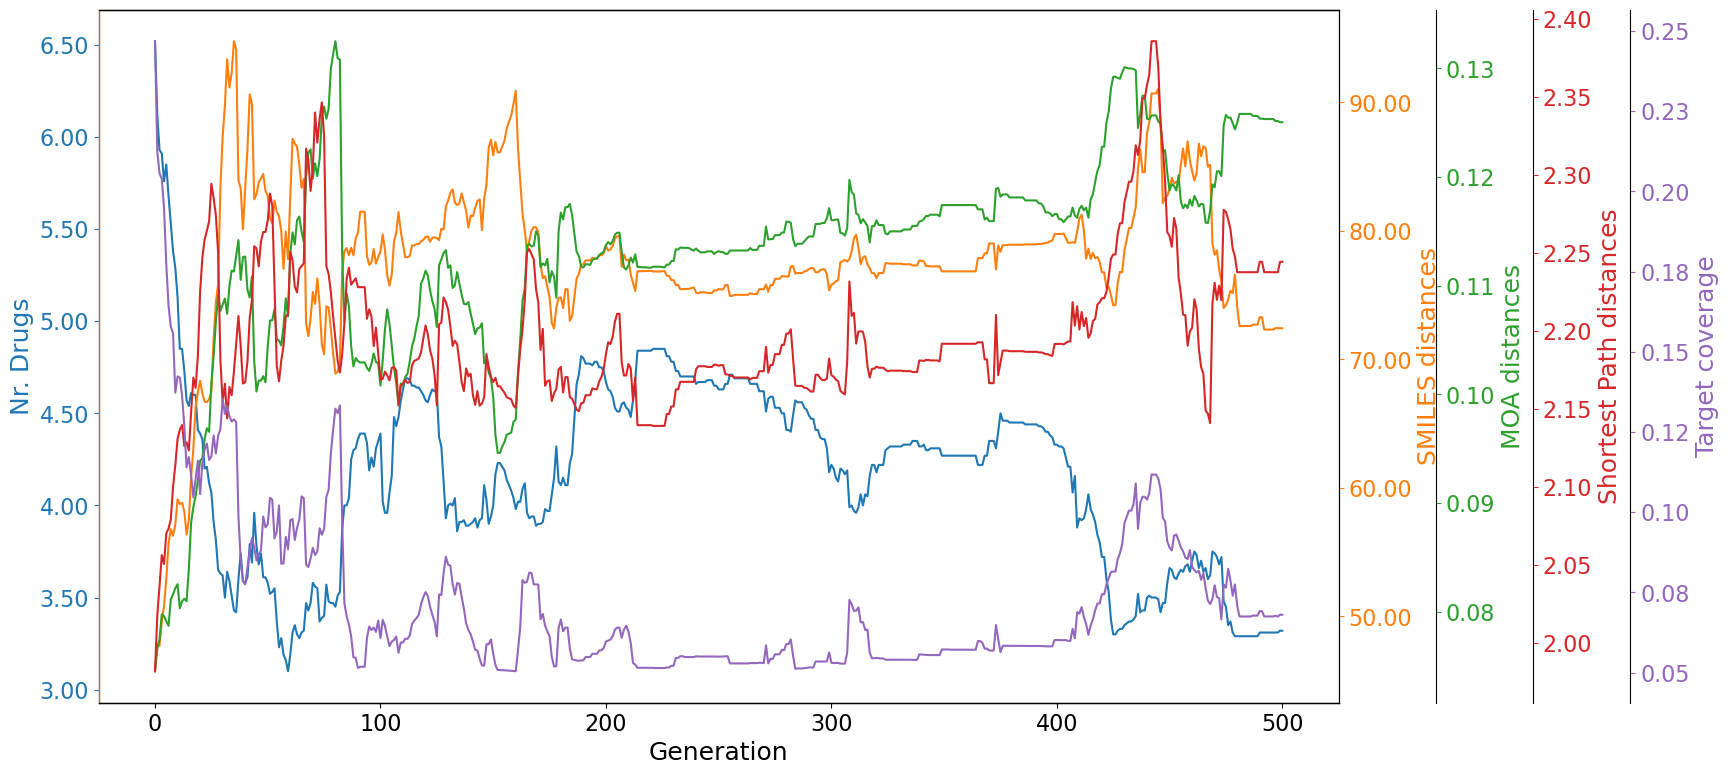

In [4]:
logbook = pd.read_json(osp.join(intermediate_path, "genetic_algorithm_run", "run001_logbook.json"))
fig, ax = plt.subplots(figsize=(16, 9))
plot_run_summary(logbook, ax=ax)

In [5]:
import itertools as it
from functools import reduce

def disease_coverage(candidate_drugs, drug_targets, ppi_network):
    # take the targets of selected drugs
    targets = set(
        drug_targets.loc[
            drug_targets["dat.drug.molecule_name"].isin(candidate_drugs),
            "dat.target.gene_info.symbol",
        ]
    )

    covered_nodes_overall = {
        ppi_network.vs["name"][n]
        for n in set(
            reduce(lambda x, y: x + y, ppi_network.neighborhood(targets, order=1))
        )
    }
    return covered_nodes_overall

def jaccard_similarity(a, b):
    return float(len(a & b)) / len(a | b)

def overlap_coefficient(a, b):
    return float(len(a & b)) / min(len(a), len(b))

In [6]:
def as_distance(dist_list):
    dist = dist_list.unstack()
    dist.iloc[:, :] = np.triu(dist.values) + np.triu(dist.values,1).T
    return dist

In [7]:
def drugs_heatmap(dist_list, method="ward"):
    dist = as_distance(dist_list)
    linkage = hc.linkage(sp.distance.squareform(dist), method=method)
    sns.clustermap(dist, row_linkage=linkage, col_linkage=linkage)
    return linkage

In [8]:
drug_targets = pd.read_csv(osp.join(intermediate_path, "drug_targets.csv"), index_col=0)
ppi_network = pd.read_csv(osp.join(intermediate_path, "ppi_network.csv"), index_col=0)
ppi_network = ig.Graph.TupleList(ppi_network.itertuples(index=False), directed=False, weights=False)
graph_rank = pd.read_csv(osp.join(intermediate_path, "graph_rank.csv"), index_col=0)

In [9]:
moa_dist = pd.read_csv(osp.join(intermediate_path, "moa_dist.csv"), index_col=[0,1]).rename(columns={"distance": "moa_dist"})
path_dist = pd.read_csv(osp.join(intermediate_path, "path_dist.csv"), index_col=[0,1]).rename(columns={"distance": "path_dist"})
smiles_dist = pd.read_csv(osp.join(intermediate_path, "smiles_dist.csv"), index_col=[0,1]).rename(columns={"distance": "smiles_dist"})

dists = pd.concat([moa_dist, path_dist, smiles_dist], axis=1)
dists = dists.assign(
    disease_dist=lambda x: x.index.map(
        lambda drugs: 1 - jaccard_similarity(
            disease_coverage([drugs[0]], drug_targets, ppi_network),
            disease_coverage([drugs[1]], drug_targets, ppi_network),
        )
    )
)

# Moa dist

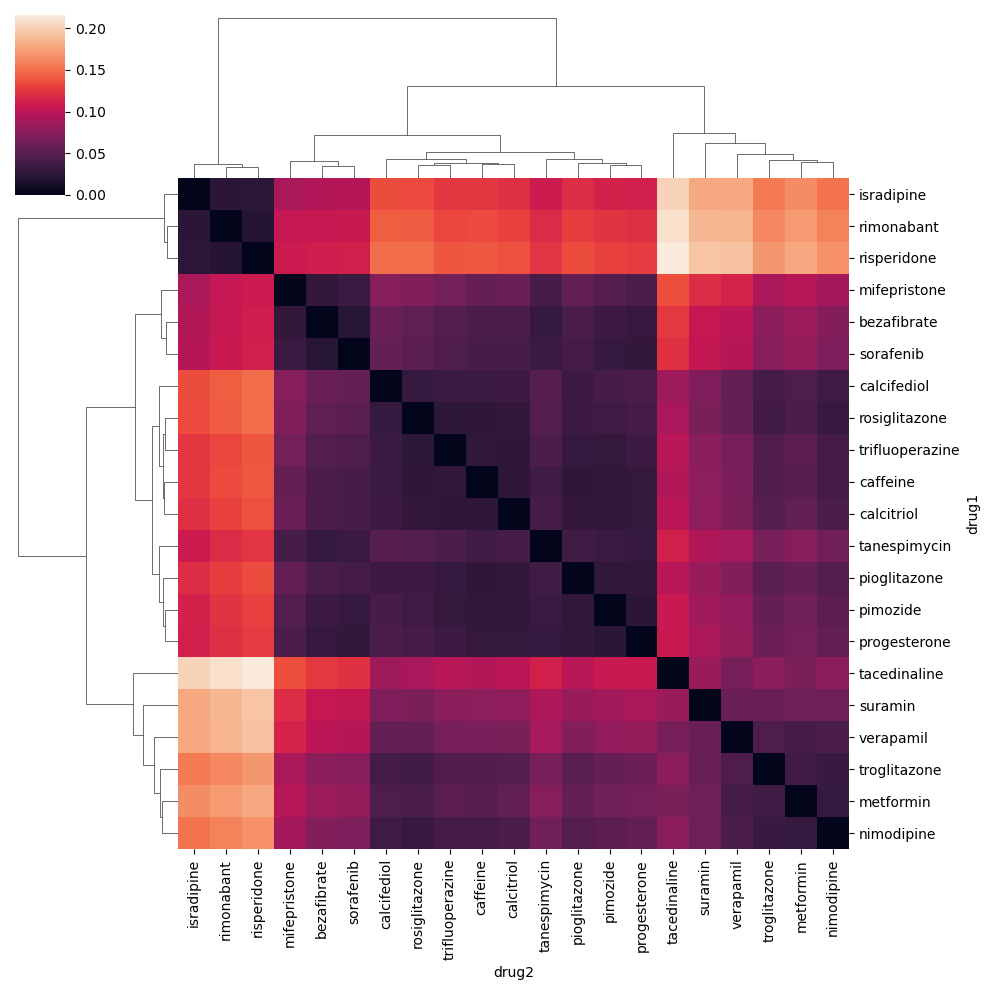

In [10]:
Z_moa = drugs_heatmap(dists["moa_dist"])

# Smiles dist

problem: `suramin` is significantly larger than other molecules, so its
distances to the rest of the other molecules, it may be worth considering to
replace or remove it from the pool

quickfix: remove `suramin` from the distance matrix

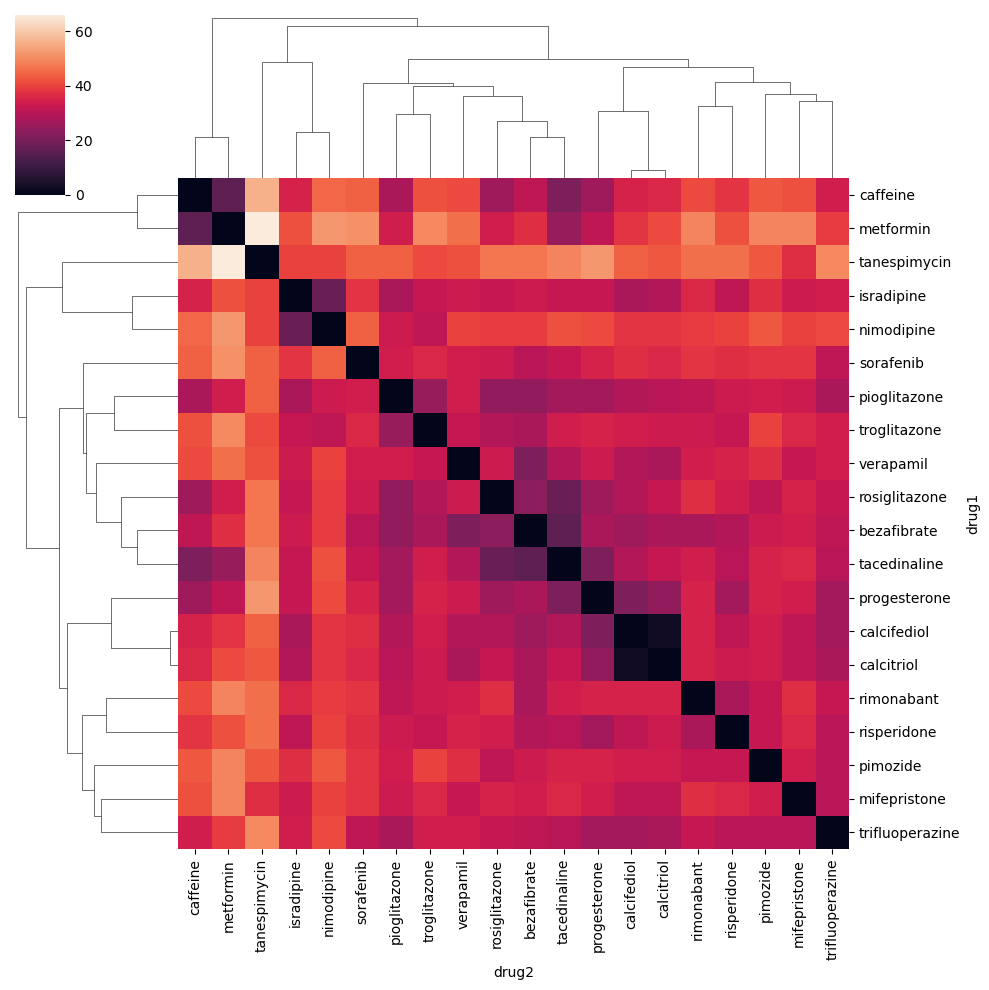

In [11]:
smiles_dist_without_suramin = (
    dists["smiles_dist"]
    .reset_index()
    .query("drug1 != 'suramin' and drug2 != 'suramin'")
    .set_index(["drug1", "drug2"])
    .squeeze()
)
Z_smiles=drugs_heatmap(smiles_dist_without_suramin)

# Shortest paths distance
problem: there are some non-zero distances on the diagonal of the distance matrix, check

quickfix: set them to 0 manually

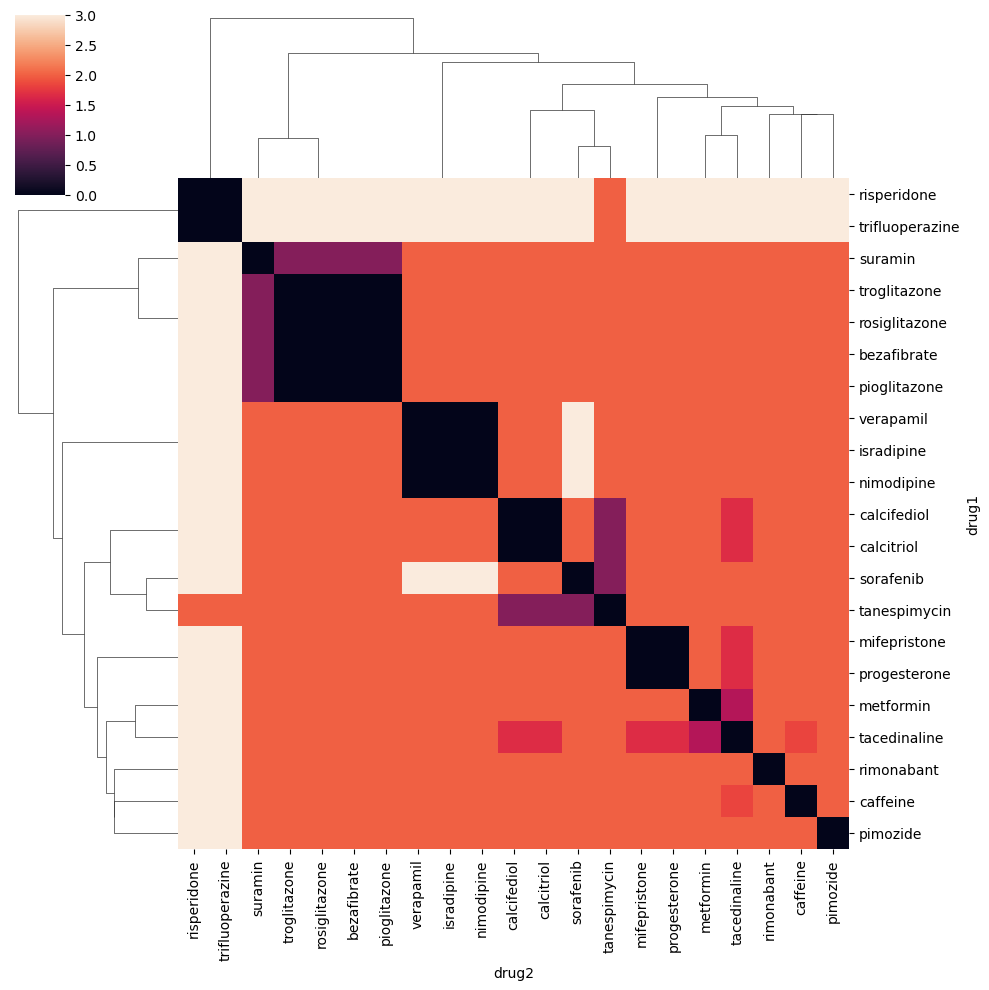

In [12]:
path_dist_zero_diag = dists["path_dist"].copy().reset_index()
path_dist_zero_diag.loc[
    path_dist_zero_diag["drug1"] == path_dist_zero_diag["drug2"], "path_dist"
] = 0
path_dist_zero_diag = path_dist_zero_diag.set_index(
    ["drug1", "drug2"]
).squeeze()
Z_paths = drugs_heatmap(path_dist_zero_diag)

# Disease network coverage dist

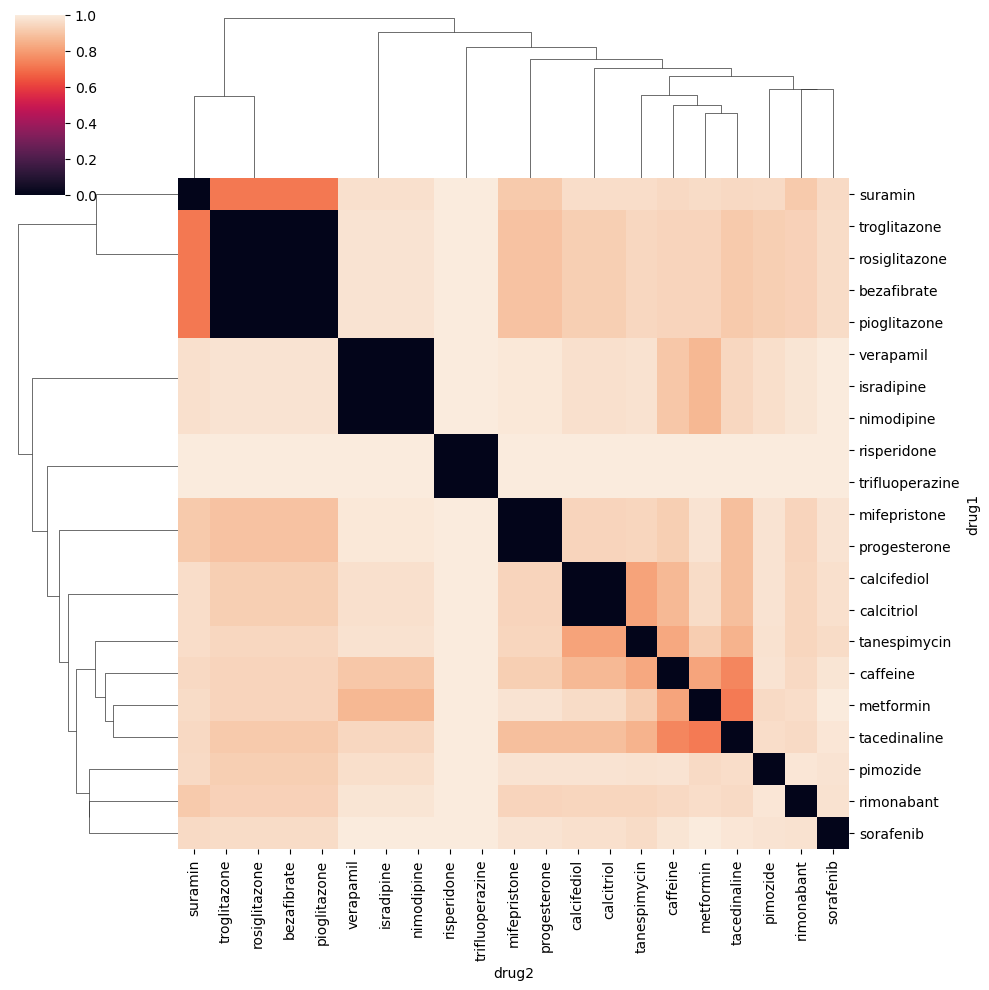

In [13]:
Z_cov = drugs_heatmap(dists["disease_dist"], method="ward")

In [14]:
clu_moa = hc.fcluster(Z_moa, 3, criterion="maxclust")
moa_assignments = pd.DataFrame(
    np.eye(3)[clu_moa - 1],
    index=as_distance(dists["moa_dist"]).index,
    columns=["moa_clust{}".format(i) for i in range(3)],
)

clu_smiles = hc.fcluster(Z_smiles, 4, criterion="maxclust")
smiles_assignments = pd.DataFrame(
    np.eye(4)[clu_smiles - 1],
    index=as_distance(smiles_dist_without_suramin).index,
    columns=["smiles_clust{}".format(i) for i in range(4)],
)

clu_paths = hc.fcluster(Z_paths, 4, criterion="maxclust")
paths_assignments = pd.DataFrame(
    np.eye(4)[clu_paths - 1], index=as_distance(dists["path_dist"]).index,
    columns=["path_clust{}".format(i) for i in range(4)],
)

clu_cov = hc.fcluster(Z_cov, 7, criterion="maxclust")
cov_assignments = pd.DataFrame(
    np.eye(7)[clu_cov - 1], index=as_distance(dists["disease_dist"]).index,
    columns=["cov_clust{}".format(i) for i in range(7)],
)

In [15]:
all_assignments = pd.concat(
    [
        moa_assignments.T,
        smiles_assignments.T,
        paths_assignments.T,
        cov_assignments.T,
    ]
).fillna(0)

In [16]:
all_assignments

drug1,bezafibrate,caffeine,calcifediol,calcitriol,isradipine,metformin,mifepristone,nimodipine,pimozide,pioglitazone,...,rimonabant,risperidone,rosiglitazone,sorafenib,suramin,tacedinaline,tanespimycin,trifluoperazine,troglitazone,verapamil
moa_clust0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
moa_clust1,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
moa_clust2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
smiles_clust0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
smiles_clust1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
smiles_clust2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
smiles_clust3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
path_clust0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
path_clust1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
path_clust2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
fact = NMF(
    n_components=10,
    alpha_H=0,
    alpha_W=0,
    init="nndsvd",
    max_iter=10000,
).fit(all_assignments.values)

In [18]:
projections = pd.DataFrame(fact.transform(all_assignments.values), index=all_assignments.index)
memberships = pd.DataFrame(fact.components_, columns=all_assignments.columns)

In [19]:
print(projections.shape)
print(memberships.shape)

(18, 10)
(10, 21)


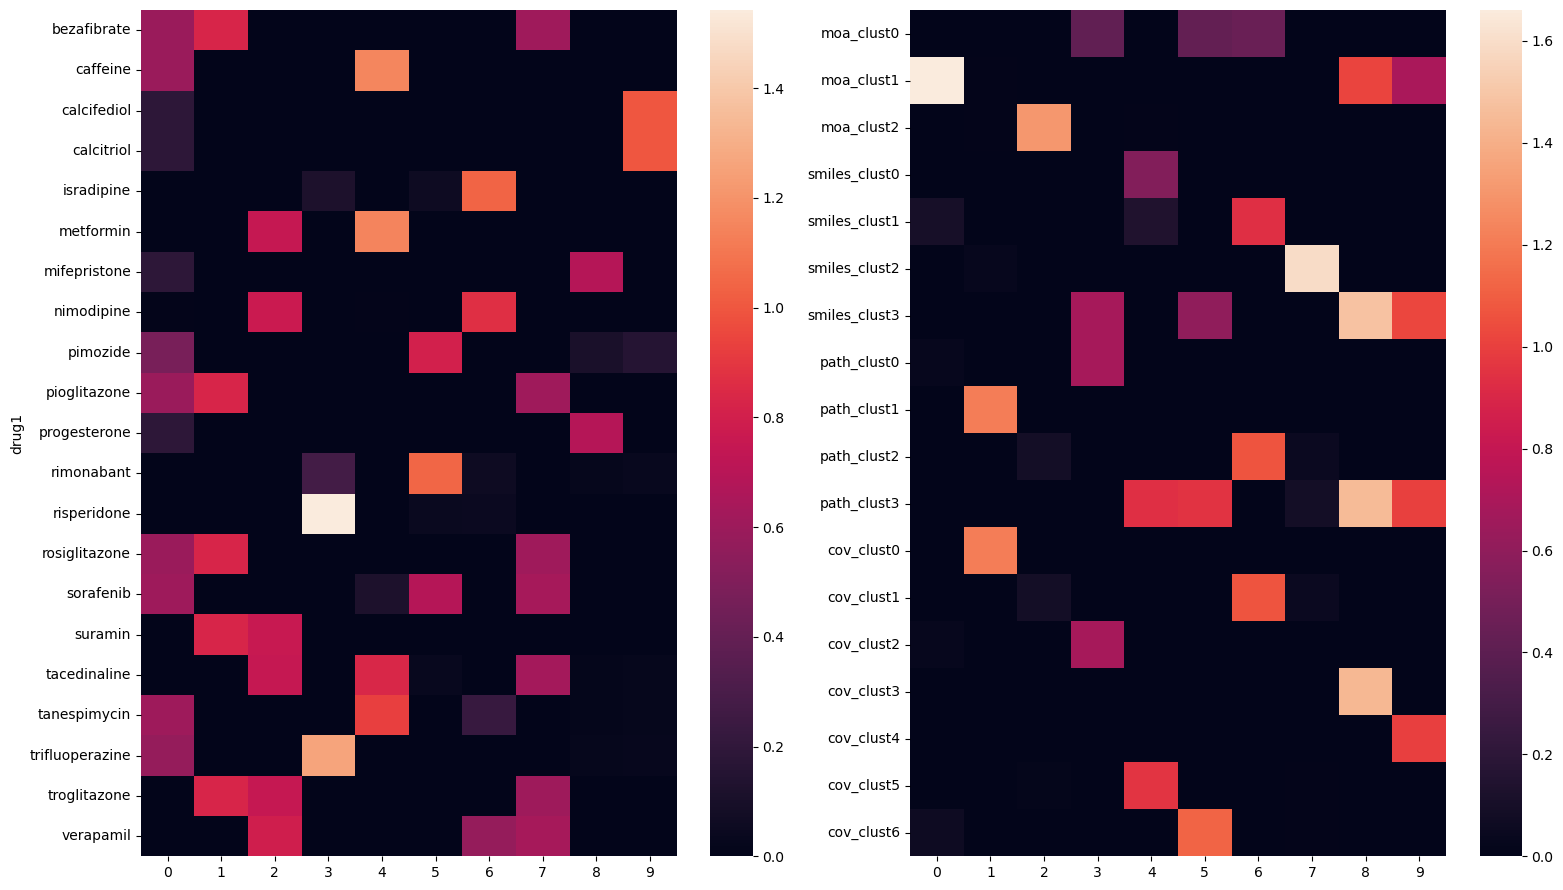

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sns.heatmap(memberships.T, ax=ax[0])
sns.heatmap(projections, ax=ax[1])
fig.tight_layout()

In [21]:
moa_idx = [0, 1, 2]
smiles_idx = [3, 4, 5, 6]
path_idx = [7, 8, 9, 10]
cov_idx = [11, 12, 13, 14, 15, 16, 17]
all_idx = [moa_idx, smiles_idx, path_idx, cov_idx]
names = ["moa", "smiles", "path", "cov"]
view_contrib = []
for n, view_idx in zip(names, all_idx):
    c = projections.iloc[view_idx].sum(axis=0) / projections.sum(axis=0)
    c.name = n
    view_contrib.append(c)
view_contrib = pd.concat(view_contrib, axis=1)

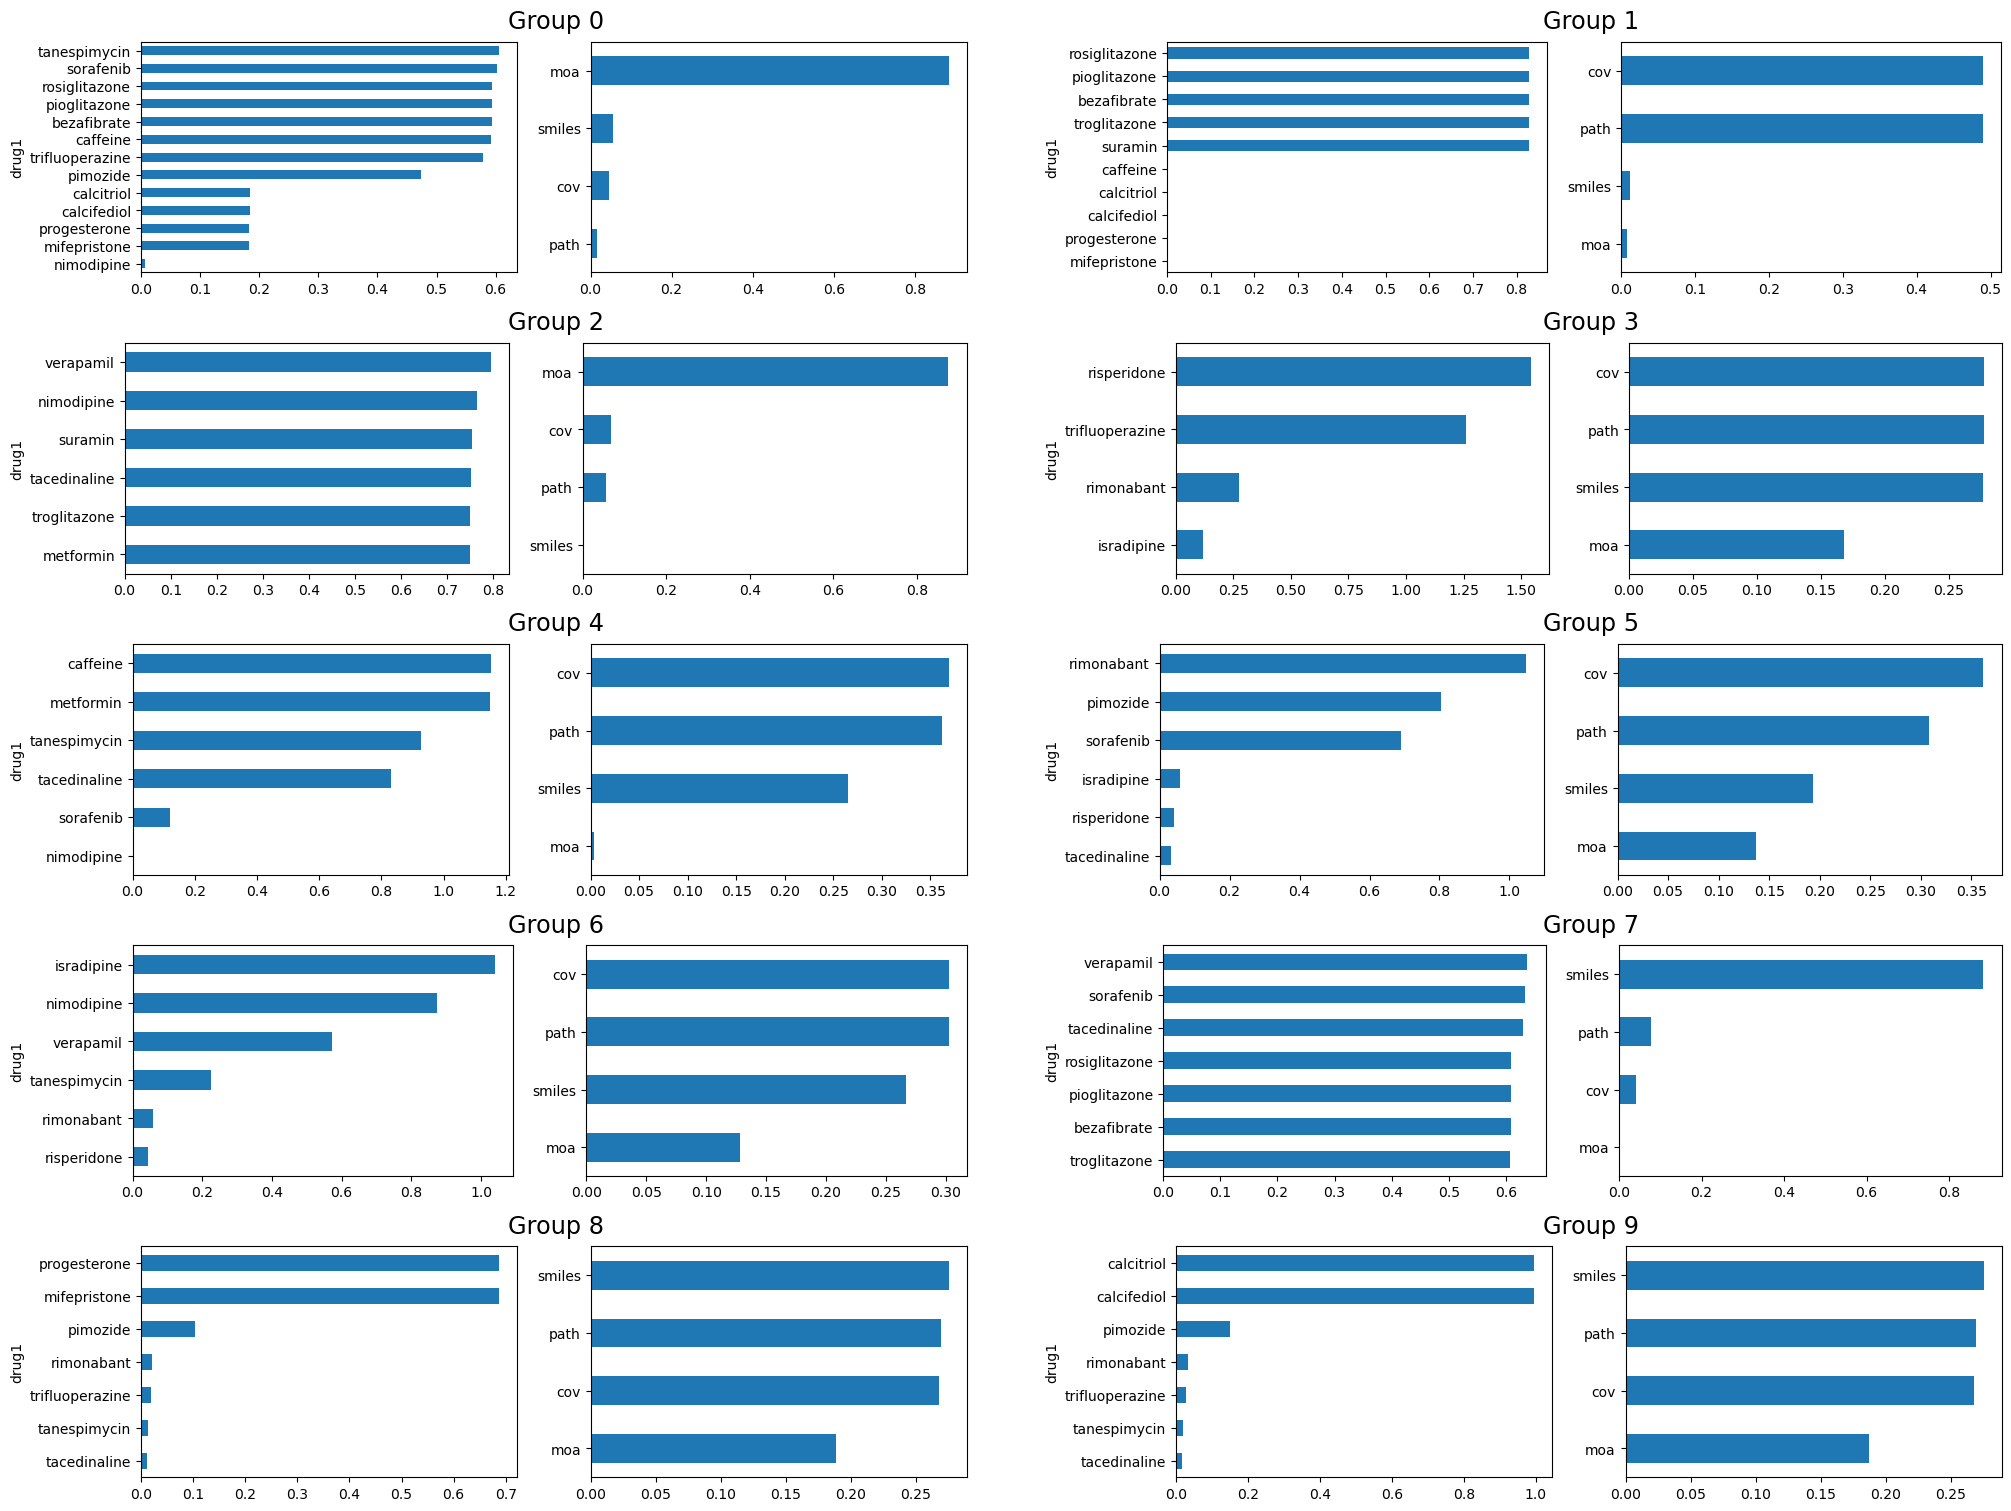

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(20, 15))
subfigs = fig.subfigures(5, 2, wspace=0.07)
for k, subfig in zip(range(10), subfigs.ravel()):
    ax = subfig.subplots(1, 2)
    memberships.loc[k, memberships.loc[k] > 0].sort_values(
        ascending=True
    ).plot(kind="barh", ax=ax[0])
    view_contrib.loc[k].sort_values(ascending=True).plot(kind="barh", ax=ax[1])
    subfig.suptitle('Group {}'.format(k), fontsize='xx-large', x=0.57)